## AIM: Train multiclass classification ML models for predicting the psychiatric diagnosis based on SSL features

SVC, RanFor & GradientBoostingClassifier for predicting psychiatric diagnosis with pretrained SSL features derived from EC resting-state EEG epochs.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import joblib
import mne
import os
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import loguniform

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

## Functions:

In [2]:
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

def check_features(file):
    df = load_file(file)
    print(df['diagnosis'].value_counts())
    display(df.sample(3))
    return df

In [3]:
def train_model(model_name, X, Y, groups, n_iter=100):
    # preprocessing steps for numerical features
    numeric_transformer = Pipeline(steps = [
        ('scaler', StandardScaler()), # standardization
        ('impute', SimpleImputer(strategy='mean')) # mean imputation
    ])

    col_trans = ColumnTransformer(transformers=[
        ('numeric_transformer', numeric_transformer, X.columns),
        ],
        remainder='drop',
        n_jobs=-1)
    
    # define score metric
    f1_scorer = make_scorer(fbeta_score, beta=1, average='macro')

    # define inner & outer CV objects
    cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls
    cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls
    
    if model_name == 'SVM':
        # hyperparameter ranges for GridSearch
        param_grid = {
        'rbf_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
        'rbf_svm__estimator__gamma': [0.1, 1, 10, 100],
        'rbf_svm__estimator__kernel': ['rbf'],
        'rbf_svm__estimator__class_weight': ['balanced']
        }

        # final pipeline
        steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
        pipeline = Pipeline(steps)

        # define gridsearch
        search = GridSearchCV(pipeline,
                                param_grid = param_grid,
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)
    
    elif model_name == 'RF':
        ## Hyperparameters for RF
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        # Number of features to consider at every split
        max_features = ['log2', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'RF__n_estimators': n_estimators,
                    'RF__max_features': max_features,
                    'RF__max_depth': max_depth,
                    'RF__min_samples_split': min_samples_split,
                    'RF__min_samples_leaf': min_samples_leaf,
                    'RF__bootstrap': bootstrap}
        
        steps = [('col_trans', col_trans), ('RF', RandomForestClassifier())]
        pipeline = Pipeline(steps)

        # define randomized search
        search = RandomizedSearchCV(pipeline,
                                    param_distributions=random_grid,
                                    n_iter=n_iter,
                                    cv = cv_inner, # use inner cv for hyperparameter tuning
                                    scoring = f1_scorer,
                                    error_score = 'raise',
                                    return_train_score = True,
                                    n_jobs=-1,
                                    verbose=1)
    
    elif model_name == 'GBC':
        ## Hyperparameters for GBC
        # Number of boosting stages to perform
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
        # Loss function to be optimized
        loss = ['log_loss']
        # Learning rate
        learning_rate = loguniform.rvs(0.001, 0.1, size=1000)
        # Fraction of samples to be used for fitting the individual base learners
        subsample = [x for x in np.linspace(0.5, 1, 5)]
        # The function to measure the quality of the split
        criterion = ['friedman_mse']
        # The min number of samples required to split an internal node
        min_samples_split = [2, 5, 10]
        # Create the random grid
        random_grid = {'gbc__n_estimators': n_estimators,
                    'gbc__loss': loss,
                    'gbc__learning_rate': learning_rate,
                    'gbc__subsample': subsample,
                    'gbc__criterion': criterion,
                    'gbc__min_samples_split': min_samples_split}

        steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier())]
        pipeline = Pipeline(steps)

        # define randomized search
        search = RandomizedSearchCV(pipeline,
                                    param_distributions=random_grid,
                                    n_iter=n_iter,
                                    cv = cv_inner, # use inner cv for hyperparameter tuning
                                    scoring = f1_scorer,
                                    error_score = 'raise',
                                    return_train_score = True,
                                    n_jobs=-1,
                                    verbose=1)
        

    # nested CV with parameter optimization to compute testing score (f1-score)
    nested_cv_search = cross_validate(search,
                                    X = X, y = Y, 
                                    cv = cv_outer, # use outer cv for model evaluation
                                    groups = groups, 
                                    fit_params={"groups": groups},
                                    scoring = f1_scorer,
                                    error_score = 'raise',
                                    return_estimator=True,
                                    return_train_score = False,
                                    verbose=1,
                                    n_jobs=-1)
    print(f'{model_name} test scores:', nested_cv_search['test_score'])
    print(f'Mean {model_name} test score:', np.mean(nested_cv_search['test_score']))
    print(f'STD {model_name} test score:', np.std(nested_cv_search['test_score']))

    return nested_cv_search, col_trans

def evaluate_model(best_model, model_name, X, Y, groups, Y_one_hot, le, col_trans):
    # final evaluation on best tuned model pipeline
    best_params = {}
    if model_name == 'SVM':
        for hyperparameter in best_model.best_params_: # get the best hyperparameters from nested CV
            key = hyperparameter[20:]
            best_params[key] = best_model.best_params_[hyperparameter]
        steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]

    elif model_name == 'RF':
        for hyperparameter in best_model.best_params_:
            key = hyperparameter[4:]
            best_params[key] = best_model.best_params_[hyperparameter]
        steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]

    elif model_name == 'GBC':
        for hyperparameter in best_model.best_params_:
            key = hyperparameter[5:]
            best_params[key] = best_model.best_params_[hyperparameter]
        steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
    
    print(best_params)
    pipeline = Pipeline(steps)

    # obtain predictions
    cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls
    Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
    class_labels = le.inverse_transform(sorted(np.unique(Y)))
    print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
    print()
    print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

    # create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    conf_matrix = confusion_matrix(Y, Y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

    # obtain proba predictions
    Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

    from sklearn.metrics import roc_auc_score

    micro_roc_auc_ovr = roc_auc_score(
        Y_one_hot,
        Y_score,
        multi_class="ovr",
        average="micro",
    )

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

    ### plot ROC curves
    from sklearn.metrics import roc_curve, auc
    n_classes = Y_one_hot.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
    for i, color in zip(range(n_classes), colors):
        ax2.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
        
    ## Compute macro-average ROC curve and AUC
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    ax2.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )    
    ## Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ax2.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )


    ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver operating characteristic for multi-class data')
    ax2.legend(loc="lower right")
    plt.show()

    # print the confusion matrix normalized by true labels
    fig, ax = plt.subplots(figsize=(8,8))
    conf_matrix = confusion_matrix(Y, Y_pred, normalize='true')
    ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', colorbar=False, ax=ax)

def pipeline_model_development(model_name, condition, feature_path, save_best=True, evaluate=True, test_run=False, n_iter=100):
    """
    Function to train & tune a model on the given features.
    param model_name: name of the model to train ['SVM', 'RF', 'GBC']
    param condition: condition of the data, e.g. 'tpos1_withinRP', used for saving the model
    param feature_path: path to the feature file
    param save_best: boolean to save the best model
    param evaluate: boolean to evaluate the model
    param test_run: boolean to run the model on a subset of the original dataframe and lower n_iter
    param n_iter: number of iterations for RandomizedSearchCV
    """
    df_features = load_file(feature_path)
    if test_run:
        # take a subset of 2 participants per class for testing
        # code snippet from GitHub Copilot
        subsampled_df = df_features.groupby('diagnosis', observed=False).apply(
        lambda x: x.groupby('ID', observed=False).head(12).sample(n=5, random_state=42), include_groups=True
        ).reset_index(drop=True)

        # Use the subsampled DataFrame for further processing
        df_features = subsampled_df
        print(f'Shape of subsampled df {df_features.shape}')

        n_iter = 5
        
    groups = df_features['ID'].tolist()
    X = df_features.drop(columns=['ID', 'diagnosis'])
    Y = df_features['diagnosis']
    print(type(X), X.shape)

    # label binarize diagnosis for ROC curve (alphabatic order by default)
    # & label encode diagnosis for predictions
    lb = preprocessing.LabelBinarizer()
    Y_one_hot = lb.fit_transform(Y)
    print(Y_one_hot.shape)
    le = preprocessing.LabelEncoder()
    Y = le.fit_transform(Y)

    nested_cv_search, col_trans_during_training = train_model(model_name, X, Y, groups, n_iter=n_iter)
    # obtain best model during nested CV
    best_score_index = np.argmax(nested_cv_search['test_score'])
    best_model = nested_cv_search['estimator'][best_score_index]
    print('Parameters of the best model:', best_model.best_params_)

    if save_best:
        # save the entire search including the best model
        joblib.dump(nested_cv_search, f'nested_cv_{model_name}_{condition}.pkl', compress=3)
    
    if evaluate:
        evaluate_model(best_model, model_name, X, Y, groups, Y_one_hot, le, col_trans_during_training)


## Obtaining data splits for DL models

In [4]:
# obtain indices for the first outer split for the ML models, to use as validation set for the DL models for model comparison (which is the same as long as shuffle=False)
from sklearn.model_selection import StratifiedGroupKFold
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False)
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False)

df_ssl_features = load_file(r'SSL_features/df_withinRP_tpos1_ShallowNet_pretext_model_features.pkl')
groups = df_ssl_features['ID'].tolist()
X = df_ssl_features.drop(columns=['ID', 'diagnosis'])
Y = df_ssl_features['diagnosis']
# split test set from data
baseline_rest_idxs, baseline_test_idxs = cv_outer.split(X, Y, groups).__next__()
X_rest, Y_rest = X.iloc[baseline_rest_idxs], Y.iloc[baseline_rest_idxs]
groups_array = np.array(groups)
groups_rest = groups_array[baseline_rest_idxs]

# split train and val set
baseline_train_idxs, baseline_val_idxs = cv_inner.split(X_rest, Y_rest, groups_rest).__next__()
groups_test = groups_array[baseline_test_idxs]
groups_train = groups_rest[baseline_train_idxs]
groups_val = groups_rest[baseline_val_idxs]
unique_groups_test = np.unique(groups_test)
unique_groups_train = np.unique(groups_train)
unique_groups_val = np.unique(groups_val)

split_indices = [unique_groups_train, unique_groups_val, unique_groups_test]
    

# save the split indices for GCN model comparison
with open('data_split_groups.pkl', 'wb') as f:
    pickle.dump(split_indices, f)

# Training models (SVC, RF, GBC):

# 4. Contrastive loss pretext task

## 4b. 3000 pretraining epochs

### SVM

<class 'pandas.core.frame.DataFrame'> (2700, 100)
(2700, 5)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.

SVM test scores: [0.25276655 0.21600129 0.26719636 0.23366226 0.20805764]
Mean SVM test score: 0.2355368200068842
STD SVM test score: 0.02208821615636306
Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.


f1_score: 0.26043067271011533

classification report:
               precision    recall  f1-score   support

        ADHD       0.26      0.16      0.19       540
     HEALTHY       0.24      0.60      0.35       540
         MDD       0.25      0.16      0.20       540
         OCD       0.23      0.13      0.16       540
         SMC       0.46      0.35      0.40       540

    accuracy                           0.28      2700
   macro avg       0.29      0.28      0.26      2700
weighted avg       0.29      0.28      0.26      2700



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


Micro-averaged One-vs-Rest ROC AUC score:
0.58


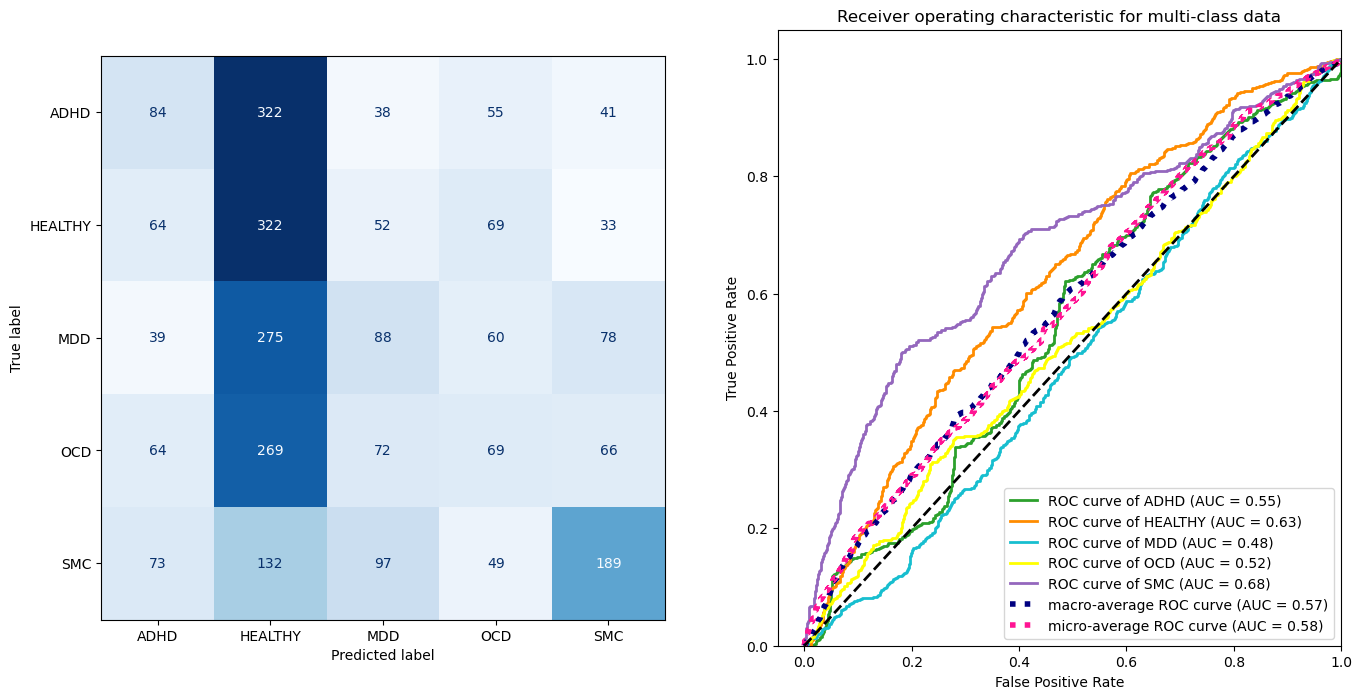

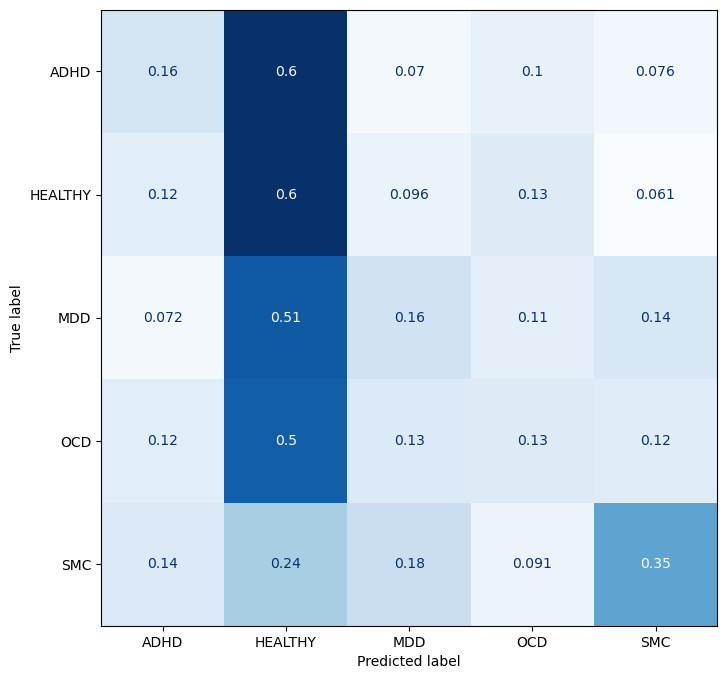

In [5]:
pipeline_model_development(
    model_name = 'SVM',
    condition = 'subsaug25f_contrastive_loss',
    feature_path = r'SSL_features/df_fullytrained_subsaug25f_contrastive_loss_ShallowNet_pretext_model_features.pkl',
    save_best=True,
    evaluate=True,
    test_run=False
)

### RF

<class 'pandas.core.frame.DataFrame'> (2700, 100)
(2700, 5)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 28.1min finished


RF test scores: [0.36519587 0.39155498 0.32628496 0.36709342 0.33222037]
Mean RF test score: 0.3564699198013282
STD RF test score: 0.02416251044868474
Parameters of the best model: {'RF__n_estimators': 1800, 'RF__min_samples_split': 10, 'RF__min_samples_leaf': 1, 'RF__max_features': 'log2', 'RF__max_depth': 110, 'RF__bootstrap': True}
{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 110, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.


f1_score: 0.3660458530225693

classification report:
               precision    recall  f1-score   support

        ADHD       0.62      0.44      0.51       540
     HEALTHY       0.32      0.47      0.38       540
         MDD       0.30      0.21      0.24       540
         OCD       0.21      0.16      0.18       540
         SMC       0.45      0.61      0.52       540

    accuracy                           0.38      2700
   macro avg       0.38      0.38      0.37      2700
weighted avg       0.38      0.38      0.37      2700



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


Micro-averaged One-vs-Rest ROC AUC score:
0.70


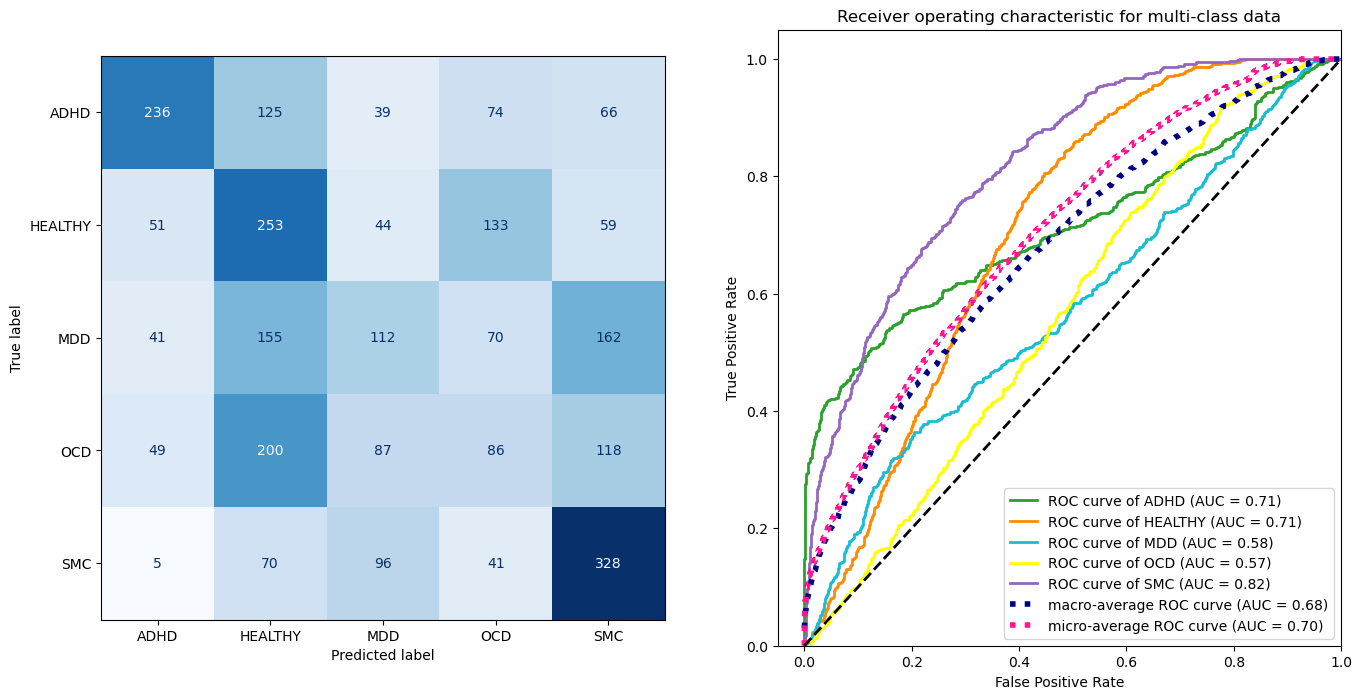

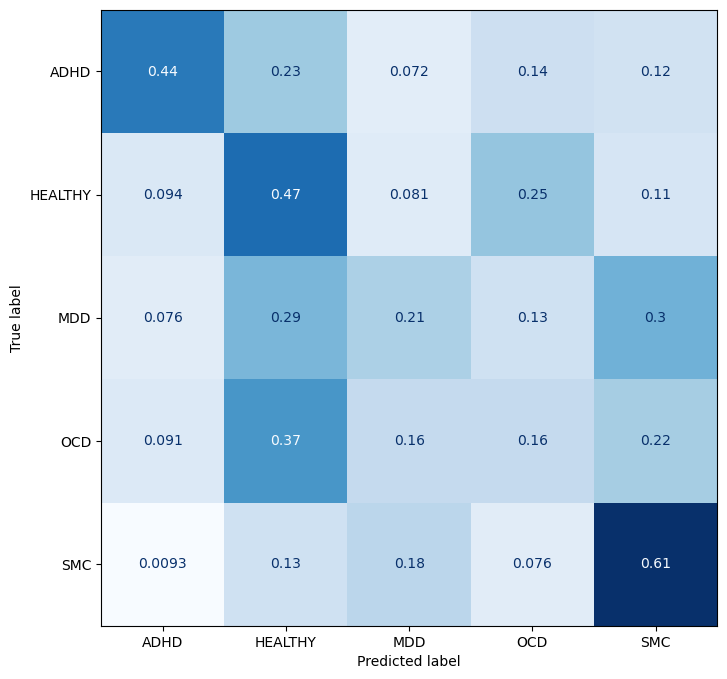

In [6]:
pipeline_model_development(
    model_name = 'RF',
    condition = 'subsaug25f_contrastive_loss',
    feature_path = r'SSL_features/df_fullytrained_subsaug25f_contrastive_loss_ShallowNet_pretext_model_features.pkl',
    save_best=True,
    evaluate=True,
    test_run=False
)

### GBC

<class 'pandas.core.frame.DataFrame'> (2700, 100)
(2700, 5)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 107.2min finished


GBC test scores: [0.36568121 0.40487014 0.33304403 0.36604095 0.31172613]
Mean GBC test score: 0.3562724917448997
STD GBC test score: 0.0318421666436698
Parameters of the best model: {'gbc__subsample': 0.625, 'gbc__n_estimators': 500, 'gbc__min_samples_split': 10, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.006453936985011525, 'gbc__criterion': 'friedman_mse'}
{'subsample': 0.625, 'n_estimators': 500, 'min_samples_split': 10, 'loss': 'log_loss', 'learning_rate': 0.006453936985011525, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


f1_score: 0.3779394276876565

classification report:
               precision    recall  f1-score   support

        ADHD       0.63      0.44      0.52       540
     HEALTHY       0.30      0.40      0.35       540
         MDD       0.30      0.22      0.26       540
         OCD       0.25      0.24      0.25       540
         SMC       0.47      0.59      0.52       540

    accuracy                           0.38      2700
   macro avg       0.39      0.38      0.38      2700
weighted avg       0.39      0.38      0.38      2700



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Micro-averaged One-vs-Rest ROC AUC score:
0.71


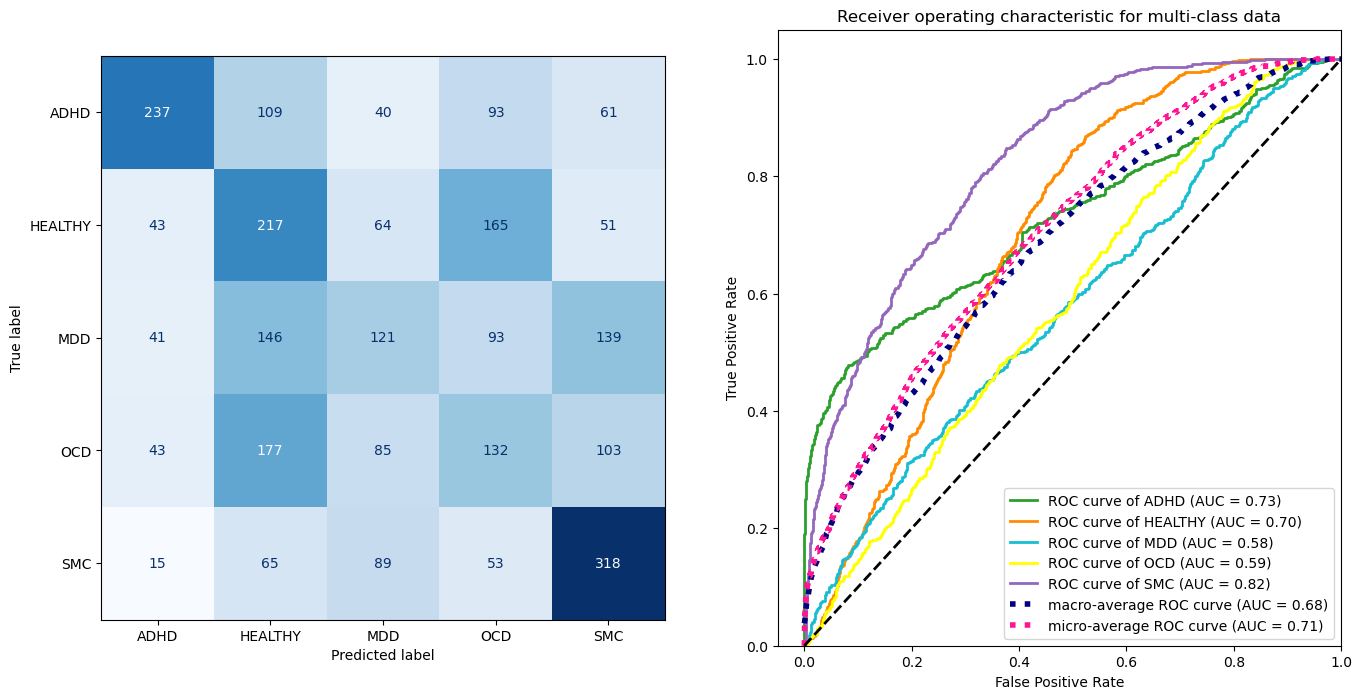

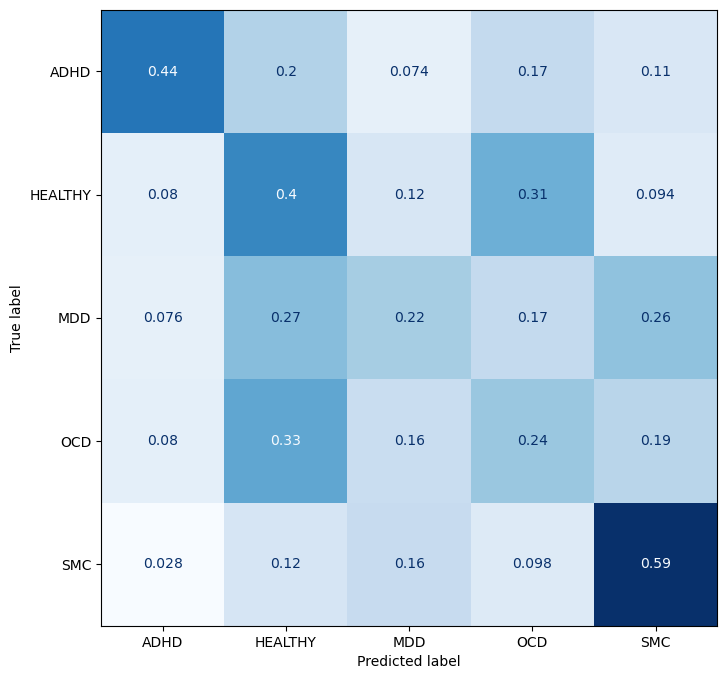

In [7]:
pipeline_model_development(
    model_name = 'GBC',
    condition = 'subsaug25f_contrastive_loss',
    feature_path = r'SSL_features/df_fullytrained_subsaug25f_contrastive_loss_ShallowNet_pretext_model_features.pkl',
    save_best=True,
    evaluate=True,
    test_run=False
)